<a href="https://colab.research.google.com/github/Vivek-23-Titan/Bidir-LSTM-HAR-Generation/blob/master/Comparison_of_Activity_Classifier_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Importing Libraries**##

In [ ]:
from __future__ import print_function, division
from matplotlib import pyplot as plt
%matplotlib inline
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
import sys

!pip install -U coremltools
import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import tensorflow.keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Reshape, Dropout, Concatenate, Embedding, Activation
from keras.layers import Input, LeakyReLU, BatchNormalization, ReLU, Conv1D, MaxPooling1D
from keras.optimizers import Adam

import keras_preprocessing
from keras_preprocessing import image

from keras import initializers
import keras.utils
from keras.utils import plot_model, np_utils
from keras import backend as K

import tensorflow as tf
print(tf.__version__)

##**Linking Drive to obtain the WISDM Dataset**##

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from zipfile import ZipFile
file_name = '/content/drive/My Drive/WISDM_ar_v1.1_raw.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# The number of steps within one time segment
TIME_PERIODS = 160
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 30

keras version  2.3.1


In [ ]:
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

# Load data set containing all the data from csv
df = read_data('/content/drive/My Drive/WISDM_ar_v1.1_raw.zip')

##**Dataset Characteristics**##

In [ ]:
# Describe the data
show_basic_dataframe_info(df)
df.head(2384612)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203



,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.0,-1.6,1.7
1098200,19,Sitting,131623371431000,9.0,-1.5,1.7
1098201,19,Sitting,131623411592000,9.1,-1.4,1.7
1098202,19,Sitting,131623491487000,9.0,-1.5,1.7


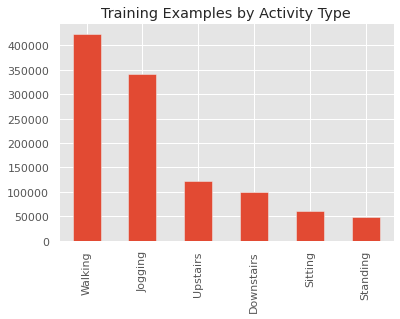

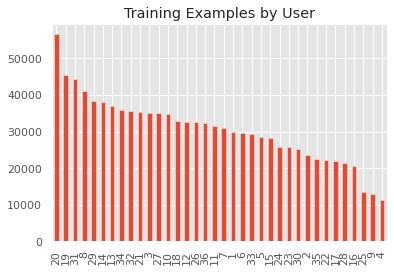

In [ ]:
# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()
# Better understand how the recordings are spread across the different
# users who participated in the study
df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

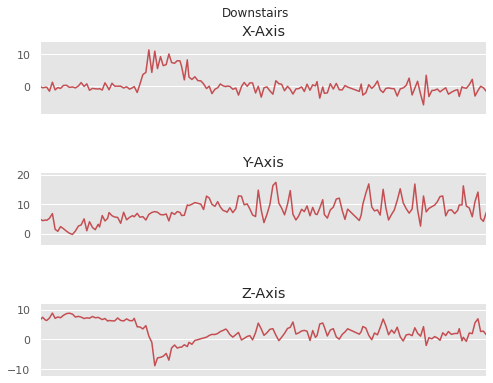

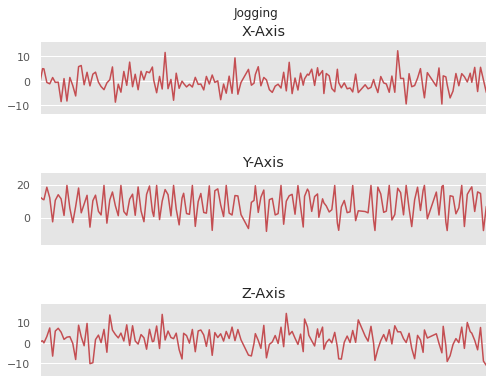

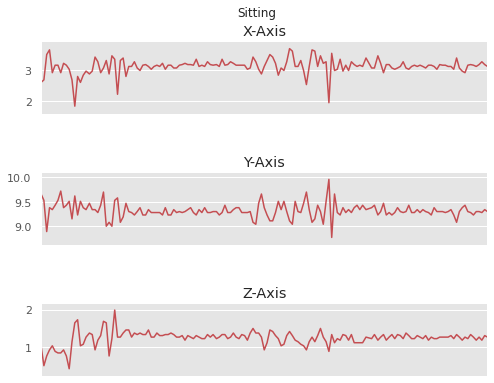

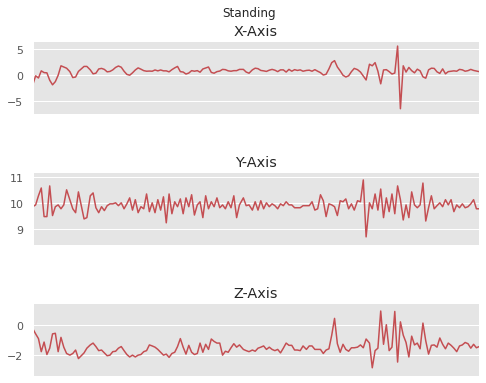

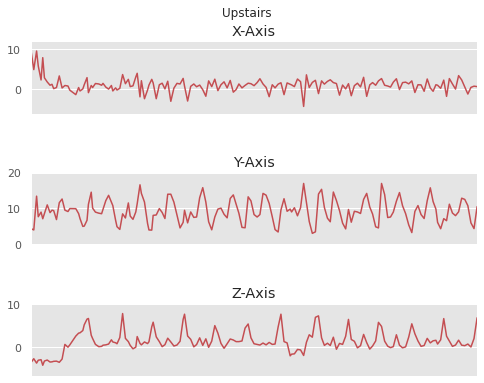

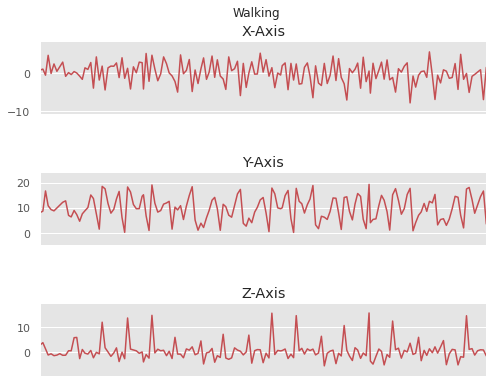

In [ ]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(8, 6),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.8)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:160]
    plot_activity(activity, subset)

In [ ]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [ ]:
# Differentiate between test set and training set
df_test = df[df['user-id'] > 33]
df_train = df[df['user-id'] <= 33]

In [ ]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})
# Normalize features for testing data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()
# Round numbers
df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [ ]:
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)
x_test, y_test = create_segments_and_labels(df_test,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [ ]:
#Saving training and testing data in different arrays
X1 = x_train
Y1 = y_train
X2 = x_test
Y2 = y_test

In [ ]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print(x_test.shape[0], 'testing samples')
print('y_test shape: ', y_test.shape)

x_train shape:  (33582, 160, 3)
33582 training samples
y_train shape:  (33582,)
x_test shape:  (3015, 160, 3)
3015 testing samples
y_test shape:  (3015,)


In [ ]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [ ]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_test = x_test.reshape(x_test.shape[0], input_shape)
print('x_test shape:', x_test.shape)
print('input_shape:', input_shape)

x_train shape: (33582, 480)
input_shape: 480
x_test shape: (3015, 480)
input_shape: 480


In [ ]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

In [ ]:
#Converting the labels into one hot vectors
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

y_test_hot = np_utils.to_categorical(y_test, num_classes)
print('New y_test shape: ', y_test_hot.shape)

New y_train shape:  (33582, 6)
New y_test shape:  (3015, 6)


In [ ]:
X = x_train
Y = y_train

In [ ]:
x_train = np.expand_dims(x_train,2)
x_test = np.expand_dims(x_test,2)

##**Upload the LSTM Generated Dataset Files**##

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Downstairs.txt to Downstairs.txt
Saving Jogging.txt to Jogging.txt
Saving Sitting.txt to Sitting.txt
Saving Standing.txt to Standing.txt
Saving Upstairs.txt to Upstairs.txt
Saving Walking.txt to Walking.txt


In [ ]:
#Load the text and store it in an numpy array format
l1 = np.loadtxt('Downstairs.txt', dtype=float)
l2 = np.loadtxt('Jogging.txt', dtype=float)
l3 = np.loadtxt('Sitting.txt', dtype=float)
l4 = np.loadtxt('Standing.txt', dtype=float)
l5 = np.loadtxt('Upstairs.txt', dtype=float)
l6 = np.loadtxt('Walking.txt', dtype=float)

In [ ]:
#Reshape the arrays into the desired format for training
l1 = np.reshape(l1,(500,480,1))
l2 = np.reshape(l2,(500,480,1))
l3 = np.reshape(l3,(500,480,1))
l4 = np.reshape(l4,(500,480,1))
l5 = np.reshape(l5,(500,480,1))
l6 = np.reshape(l6,(500,480,1))

In [ ]:
#Prepare the generated data sequence labels for each of the activities
y = []
for i in range(len(l1)*6):
  if i<(len(l1)*1):
    y.append([0])
  if i>=(len(l1)*1) and i<(len(l1)*2):
    y.append([1])
  if i>=(len(l1)*2) and i<(len(l1)*3):
    y.append([2])
  if i>=(len(l1)*3) and i<(len(l1)*4):
    y.append([3])
  if i>=(len(l1)*4) and i<(len(l1)*5):
    y.append([4])
  if i>=(len(l1)*5) and i<(len(l1)*6):
    y.append([5])

In [ ]:
#Shape of the generated data sequence labels
y = np.array(y)
y.shape

(3000, 1)

In [ ]:
#Combine all the difference activity data sequences
x = np.concatenate((l1,l2,l3,l4,l5,l6))
x.shape

(3000, 480, 1)

In [ ]:
#Again transform the generated activity labels to one hot vectors
from keras.utils import to_categorical

y = to_categorical(y)
print(y.shape)

(3000, 6)


In [ ]:
y_train_hot.shape
y.shape

(3000, 6)

In [ ]:
#Combine the generated activity data with the original dataset to increase the dataset size for training
x1 = np.concatenate((x_train,x))
y1 = np.concatenate((y_train_hot,y))

In [ ]:
A1 = x1
B1 = y1
A2 = x_test
B2 = y_test_hot

In [ ]:
x1 = A1
y1 = B1
x_test = A2
y_test_hot = B2

In [ ]:
#Shuffle the Dataset entries

from sklearn.utils import shuffle

for i in range(100):
  x_train, y_train_hot = shuffle(x_train, y_train_hot, random_state=0)

  x_test, y_test_hot = shuffle(x_test, y_test_hot, random_state=0)

  x, y = shuffle(x, y, random_state=0)

  x1, y1 = shuffle(x1, y1, random_state=0)

##**Activity Classifier on Original Dataset**##

In [ ]:
#Build a 1-D Convolution Activity Classifier
model1 = Sequential()
model1.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform',input_shape=(480,1)))
model1.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model1.add(Dropout(0.6))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(50, activation='relu'))
model1.add(Dense(6, activation='softmax'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 478, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 476, 32)           3104      
_________________________________________________________________
dropout_1 (Dropout)          (None, 476, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 238, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7616)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                380850    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                

In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer=Adam(lr = 0.0002), metrics=['accuracy'])

In [ ]:
#Train model1 for 100 epochs
history1 = model1.fit(x=x_train, y=y_train_hot, batch_size=32, epochs = 100, verbose=1,validation_data = (x_test,y_test_hot), shuffle = True)

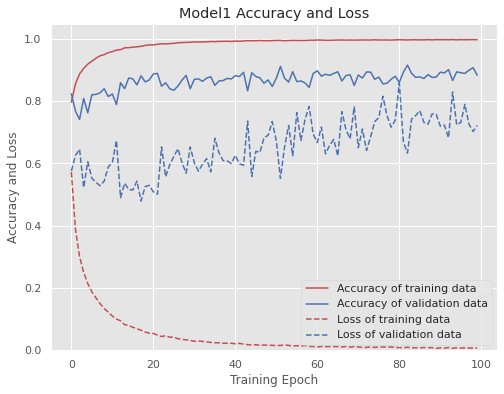

In [ ]:
#Plot the training history of the model trained on original dataset
plt.figure(figsize=(8, 6))
plt.plot(history1.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history1.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history1.history['loss'], 'r--', label='Loss of training data')
plt.plot(history1.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model1 Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

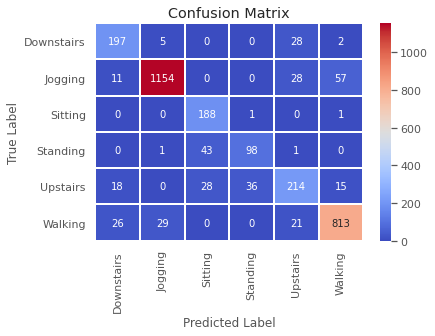

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       232
           1       0.97      0.92      0.95      1250
           2       0.73      0.99      0.84       190
           3       0.73      0.69      0.71       143
           4       0.73      0.69      0.71       311
           5       0.92      0.91      0.92       889

    accuracy                           0.88      3015
   macro avg       0.81      0.84      0.82      3015
weighted avg       0.89      0.88      0.88      3015



In [ ]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model1.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test_hot, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

In [ ]:
#Final testing accuracy on the test dataset
test_loss,test_acc=model1.evaluate(x_test, y_test_hot)
print(test_loss,test_acc*100)

3015/3015 [==============================] - 0s 109us/step
0.7219075807268309 88.35821151733398


##**Activity Classifier on Combined Dataset**##

In [ ]:
#Build and train another model on the combined dataset
model2 = Sequential()
model2.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform',input_shape=(480,1)))
model2.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model2.add(Dropout(0.6))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(50, activation='relu'))
model2.add(Dense(6, activation='softmax'))
#model2.summary()

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer=Adam(lr = 0.0002), metrics=['accuracy'])

In [ ]:
#Note: Validation results may vary sometimes with shuffing and data arrangement
history2 = model2.fit(x=x1, y=y1, batch_size=32, epochs = 100, verbose=1,validation_data = (x_test,y_test_hot), shuffle = True)

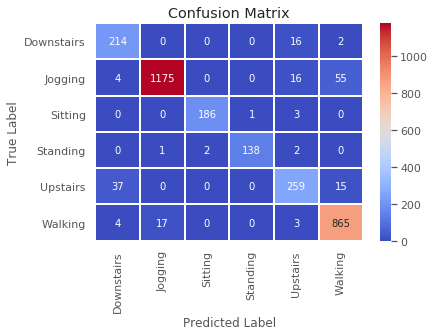

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       232
           1       0.98      0.94      0.96      1250
           2       0.99      0.98      0.98       190
           3       0.99      0.97      0.98       143
           4       0.87      0.83      0.85       311
           5       0.92      0.97      0.95       889

    accuracy                           0.94      3015
   macro avg       0.93      0.94      0.93      3015
weighted avg       0.94      0.94      0.94      3015



In [ ]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model2.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test_hot, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

In [ ]:
#Final test dataset accuracy
test_loss,test_acc=model2.evaluate(x_test, y_test_hot)
print(test_loss,test_acc*100)

3015/3015 [==============================] - 0s 52us/step
0.4909047327642244 94.09618573797678


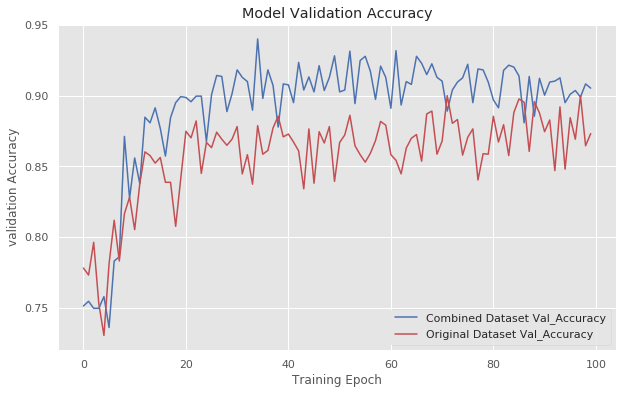

              precision    recall  f1-score   support

         0.0       0.09      0.50      0.16      3116
         1.0       0.27      0.00      0.00     10159
         2.0       0.05      0.03      0.04      1806
         3.0       0.04      0.04      0.04      1468
         4.0       0.11      0.01      0.02      3780
         5.0       0.40      0.44      0.42     13253

    accuracy                           0.22     33582
   macro avg       0.16      0.17      0.11     33582
weighted avg       0.27      0.22      0.19     33582



In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history2.history['val_accuracy'], 'b', label='Combined Dataset Val_Accuracy')
plt.plot(history1.history['val_accuracy'], 'r', label='Original Dataset Val_Accuracy')

plt.title('Model Validation Accuracy')
plt.ylabel('validation Accuracy')
plt.xlabel('Training Epoch')
plt.legend()
plt.show()